Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
#.png "notMNIST_large/A/aXJyZXAudHRm.png"
from IPython.display import Image
display(Image(filename="notMNIST_large/A/aXJyZXAudHRm.png"))

In [5]:
display(Image(filename="notMNIST_small/A/MTh0aENlbnR1cnkudHRm.png"))

In [6]:
display(Image(filename="notMNIST_small/I/MTggSG9sZXMgQlJLLnR0Zg==.png"))

In [7]:
display(Image(filename="notMNIST_small/C/MTggSG9sZXMgQlJLLnR0Zg==.png"))

In [8]:
display(Image(filename="notMNIST_large/A/aXJyZXAudHRm.png"))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [10]:
print("Verifiyng training shapes ,first row , mean and std  of restored numpy arrays");

for name in train_datasets:
    connection = open(name,"rb");
    content = pickle.load(connection);
    connection.close();
    print ("Verifiyng for:",name, "shape" ,content.shape," mean:",np.mean(content)," standard deviation:",np.std(content));
    print ("First row:",content[0][0]);
    


Verifiyng training shapes ,first row , mean and std  of restored numpy arrays
Verifiyng for: notMNIST_large/A.pickle shape (52909, 28, 28)  mean: -0.12825  standard deviation: 0.443121
First row: [-0.5        -0.5        -0.5        -0.5        -0.48431373 -0.5
 -0.19019608  0.46862745  0.49215686  0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5         0.5
  0.49215686  0.46862745 -0.19019608 -0.5        -0.48431373 -0.5        -0.5
 -0.5        -0.5       ]
Verifiyng for: notMNIST_large/B.pickle shape (52911, 28, 28)  mean: -0.00756304  standard deviation: 0.454491
First row: [ 0.0254902  -0.5        -0.49215686 -0.49607843 -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5       ]
Verifiyng for: notMNIST_large/C.pickle shape (529

Plotting images of restored training numpy arrays:


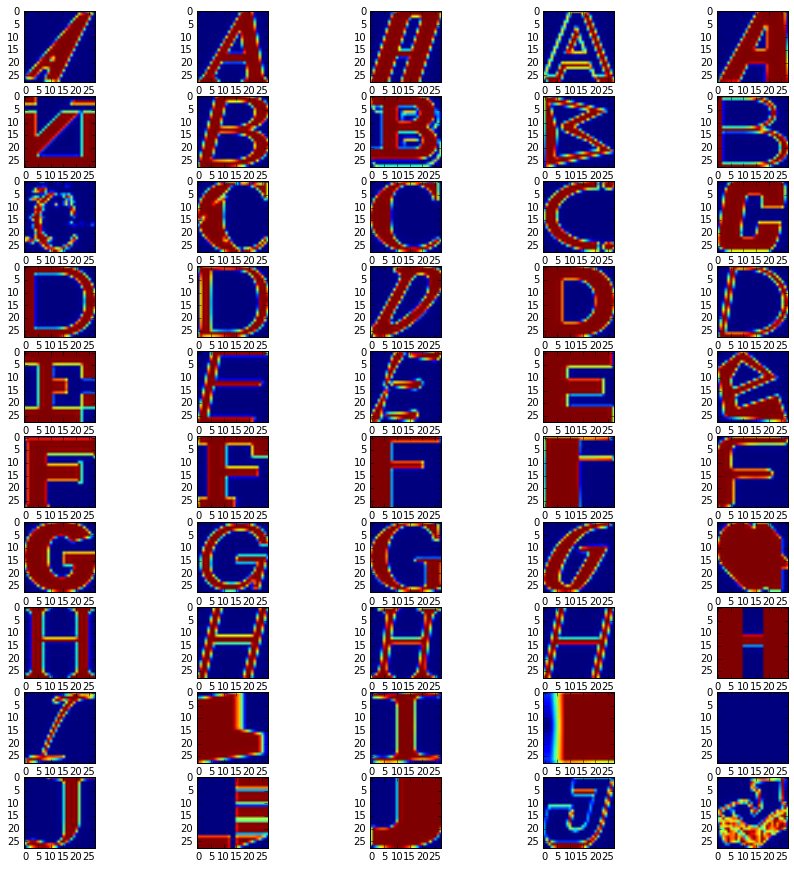

In [11]:
print ("Plotting images of restored training numpy arrays:");

myFigure = plt.figure();
myFigure.set_figwidth(15);
myFigure.set_figheight(15); 

#generate images for ervery letter
for index,name in enumerate(train_datasets):
    connection = open(name,"rb");
    content = pickle.load(connection);
    connection.close();
    
    #generate 5 random images
    for i in range(0,5):    
        ax = myFigure.add_subplot(len(train_datasets), 5, index*5+i+1)
        #ax = plt.imshow(content[np.random.choice(len(content),1)]);
        image_number= int(np.random.choice(len(content),1));
        image = content[ image_number];
        ax = plt.imshow(image);
  

Plotting images of restored test numpy arrays:


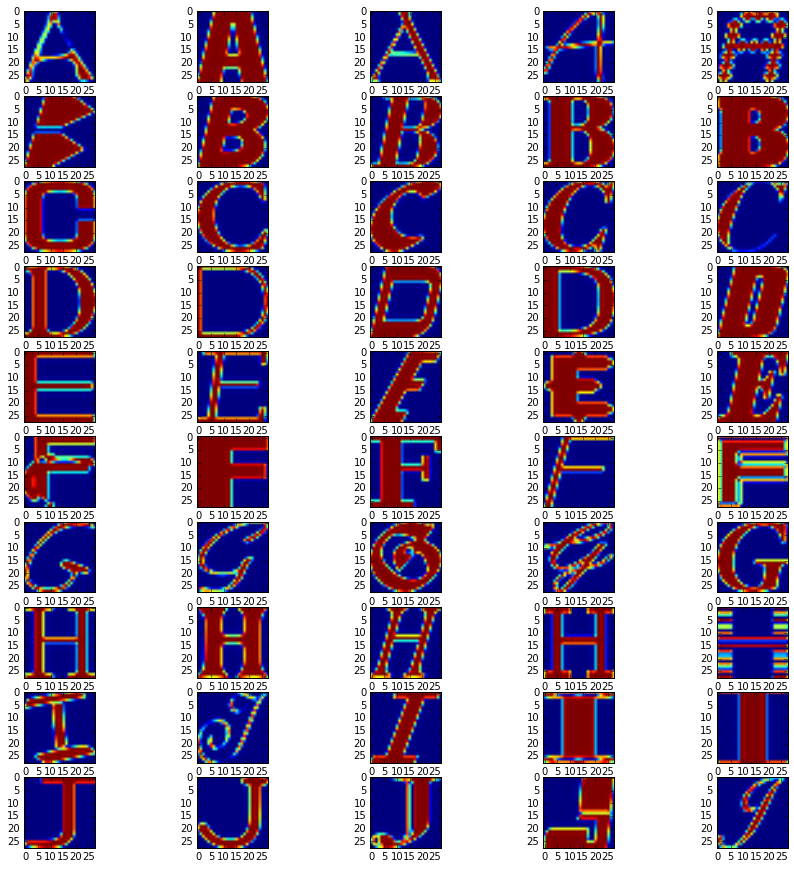

In [12]:
print ("Plotting images of restored test numpy arrays:");

myFigure = plt.figure();
myFigure.set_figwidth(15);
myFigure.set_figheight(15); 

#generate images for ervery letter
for index,name in enumerate(test_datasets):
    connection = open(name,"rb");
    content = pickle.load(connection);
    connection.close();
    
    #generate 5 random images
    for i in range(0,5):    
        ax = myFigure.add_subplot(len(train_datasets), 5, index*5+i+1)
        image_number= int(np.random.choice(len(content),1));
        image = content[ image_number];
        ax = plt.imshow(image);
  

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [13]:
#Verify that the number of elements in each class is equivalent  and  with similar variations,and reverify near 0 means
total_train_size = 0;
for name in train_datasets:
    connection = open(name,"rb");
    content = pickle.load(connection);
    connection.close();
    total_train_size = total_train_size + len(content);
    print("For ",name,":",len(content)," elements, std is:",np.std(content)," and mean:",np.mean(content));
    
print("Total train size:",total_train_size );

For  notMNIST_large/A.pickle : 52909  elements, std is: 0.443121  and mean: -0.12825
For  notMNIST_large/B.pickle : 52911  elements, std is: 0.454491  and mean: -0.00756304
For  notMNIST_large/C.pickle : 52912  elements, std is: 0.439807  and mean: -0.142258
For  notMNIST_large/D.pickle : 52911  elements, std is: 0.455648  and mean: -0.0573677
For  notMNIST_large/E.pickle : 52912  elements, std is: 0.452942  and mean: -0.069899
For  notMNIST_large/F.pickle : 52912  elements, std is: 0.44709  and mean: -0.125583
For  notMNIST_large/G.pickle : 52912  elements, std is: 0.44624  and mean: -0.0945815
For  notMNIST_large/H.pickle : 52912  elements, std is: 0.454232  and mean: -0.068522
For  notMNIST_large/I.pickle : 52912  elements, std is: 0.468899  and mean: 0.0307862
For  notMNIST_large/J.pickle : 52911  elements, std is: 0.443656  and mean: -0.153358
Total train size: 529114


In [14]:
total_test_size = 0;
for name in test_datasets:
    connection = open(name,"rb");
    content = pickle.load(connection);
    connection.close();
    total_test_size = total_test_size + len(content);
    print("For ",name,":",len(content)," elements, std is:",np.std(content)," and mean:",np.mean(content));
    
print("Total test size:",total_test_size );

For  notMNIST_small/A.pickle : 1872  elements, std is: 0.445128  and mean: -0.132626
For  notMNIST_small/B.pickle : 1873  elements, std is: 0.457115  and mean: 0.00535608
For  notMNIST_small/C.pickle : 1873  elements, std is: 0.44269  and mean: -0.141521
For  notMNIST_small/D.pickle : 1873  elements, std is: 0.459759  and mean: -0.0492167
For  notMNIST_small/E.pickle : 1873  elements, std is: 0.45735  and mean: -0.0599148
For  notMNIST_small/F.pickle : 1872  elements, std is: 0.452279  and mean: -0.118185
For  notMNIST_small/G.pickle : 1872  elements, std is: 0.449006  and mean: -0.0925503
For  notMNIST_small/H.pickle : 1872  elements, std is: 0.458759  and mean: -0.0586892
For  notMNIST_small/I.pickle : 1872  elements, std is: 0.471894  and mean: 0.052645
For  notMNIST_small/J.pickle : 1872  elements, std is: 0.448014  and mean: -0.151689
Total test size: 18724


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [15]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 51909
valid_size = 10000
test_size = 10000


valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (51909, 28, 28) (51909,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [16]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Verifing train set
Examples for  -1713323064


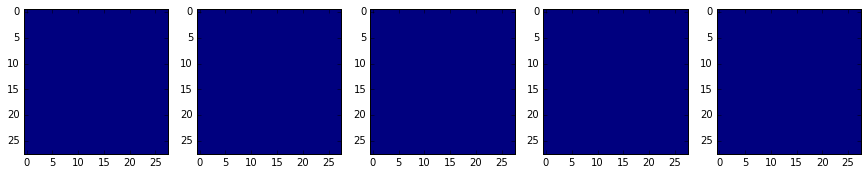

Examples for  -1016826623


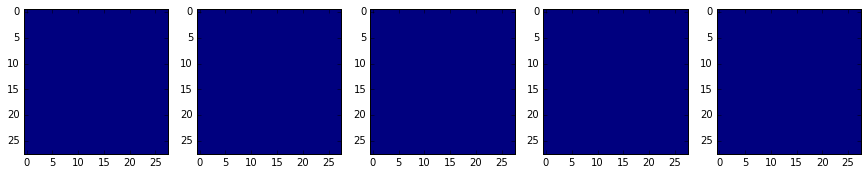

Examples for  -467937244


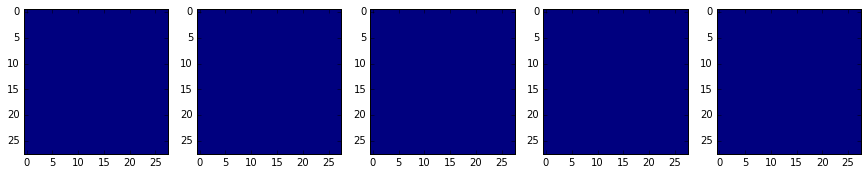

Examples for  -404854903


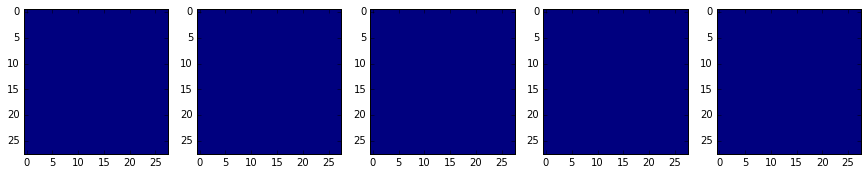

Examples for  0


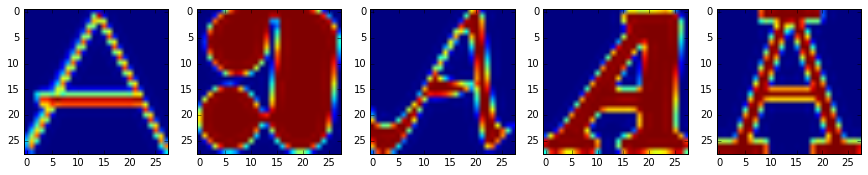

Examples for  1


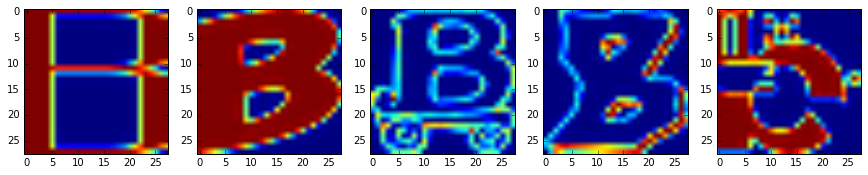

Examples for  2


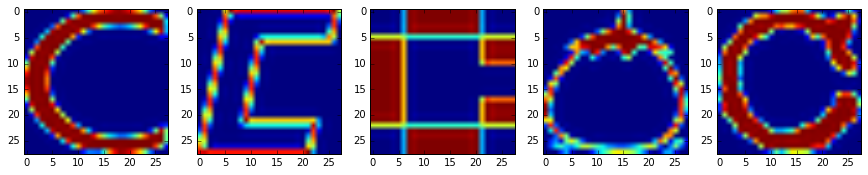

Examples for  3


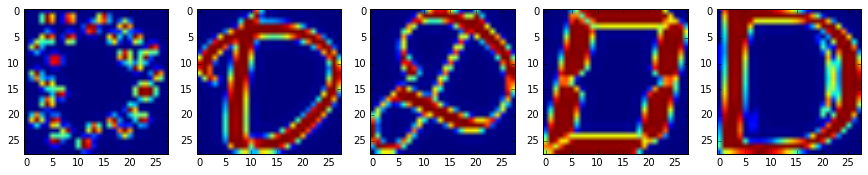

Examples for  4


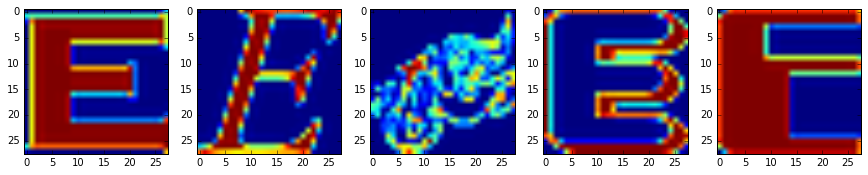

Examples for  5


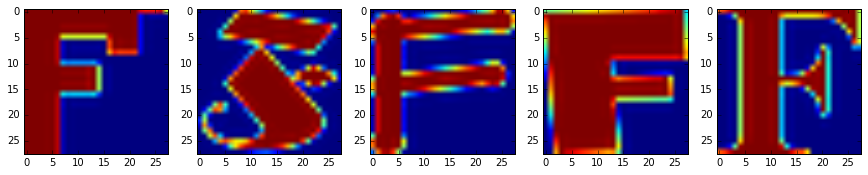

Examples for  6


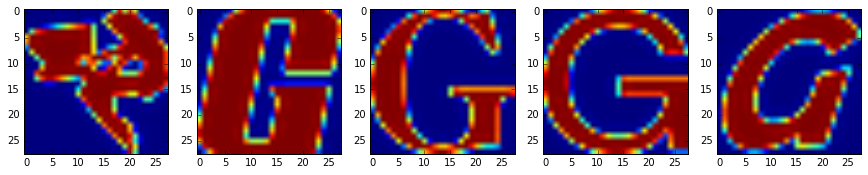

Examples for  7


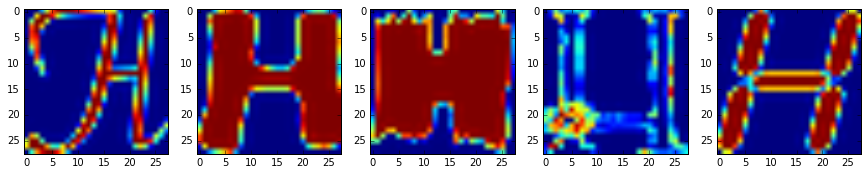

Examples for  8


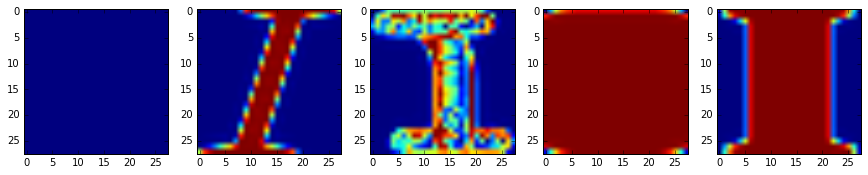

Examples for  9


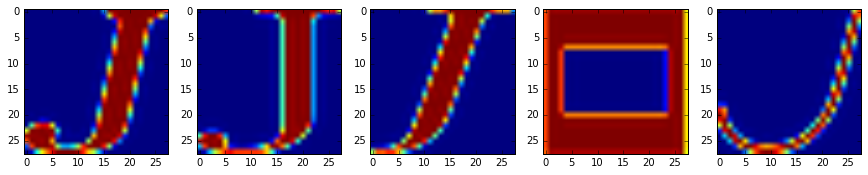

Examples for  211039301


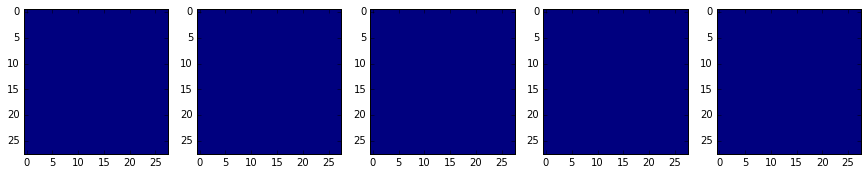

Examples for  238494594


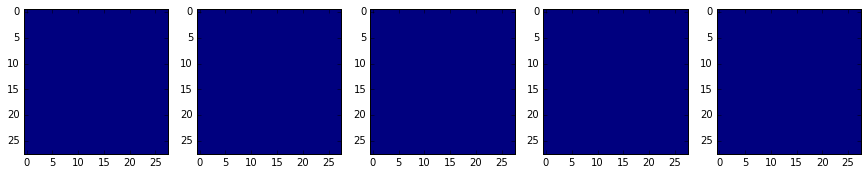

Examples for  670924759


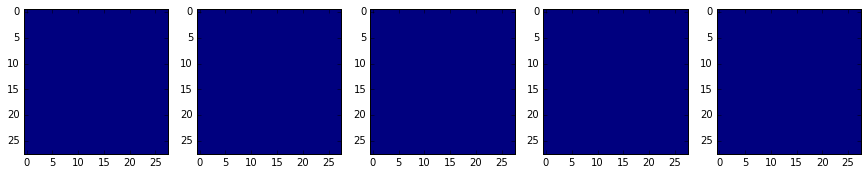

Examples for  2027087500


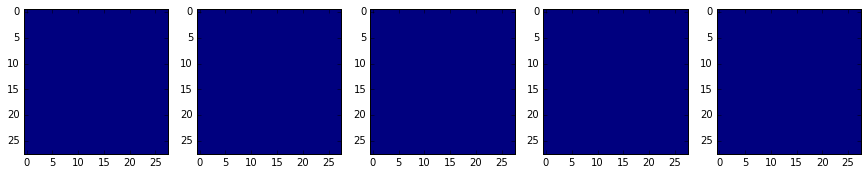

Examples for  2076230143


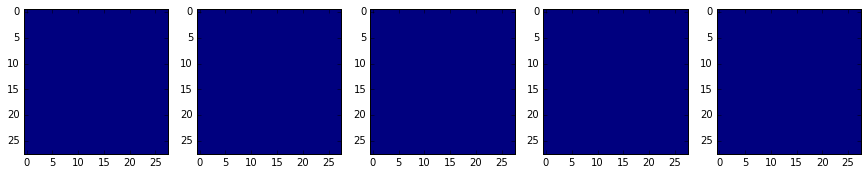

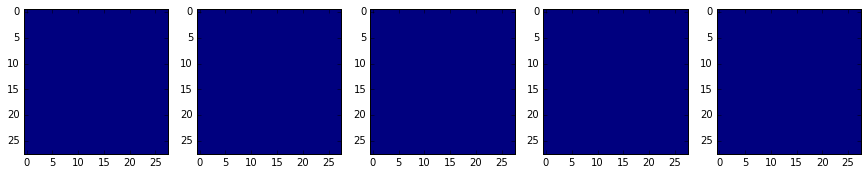

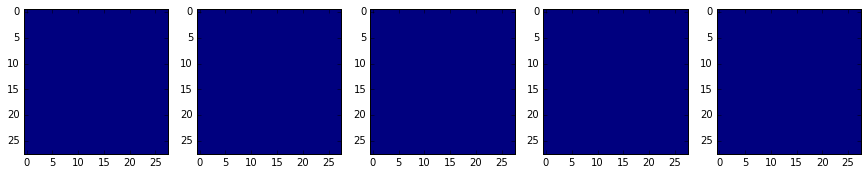

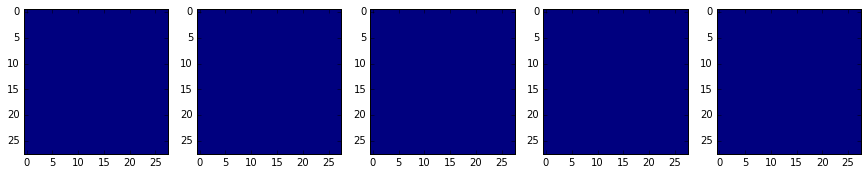

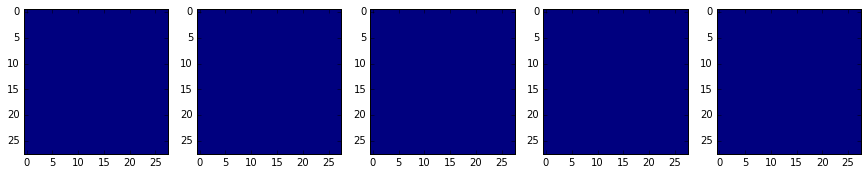

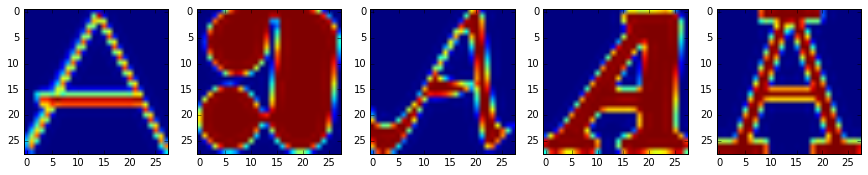

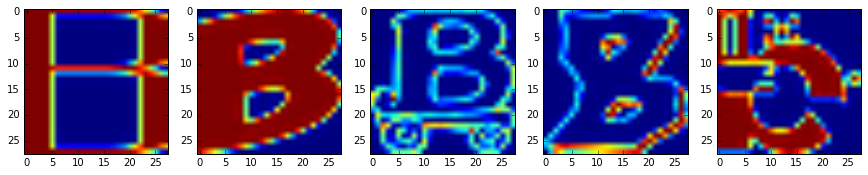

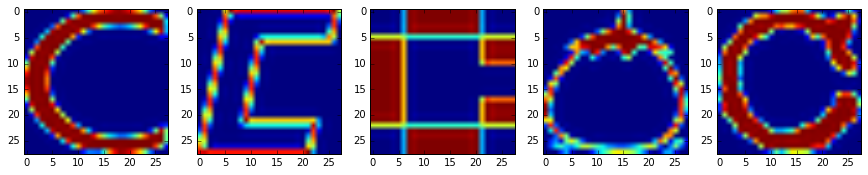

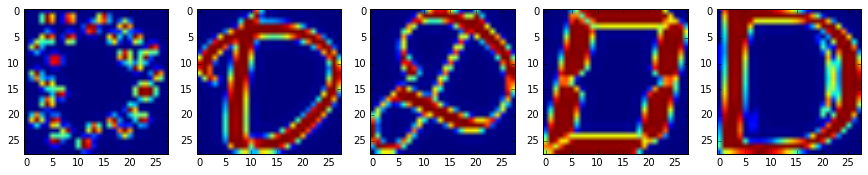

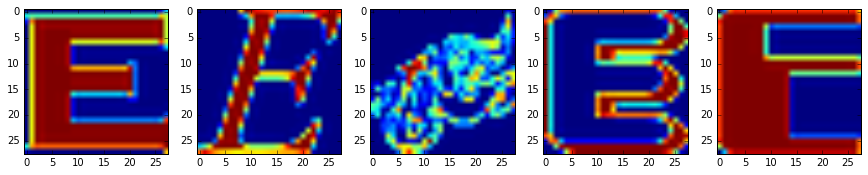

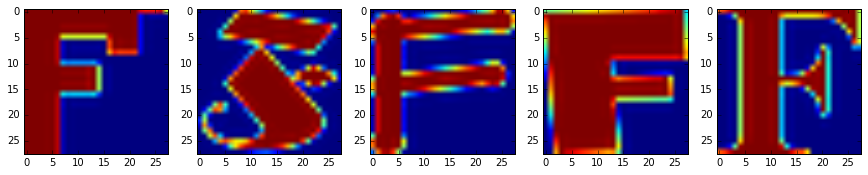

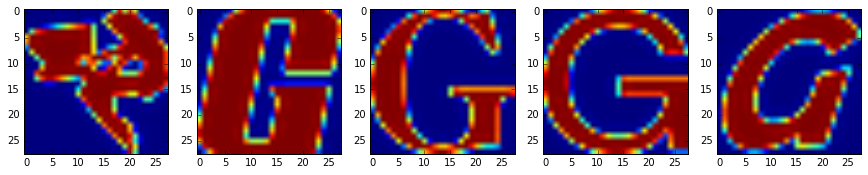

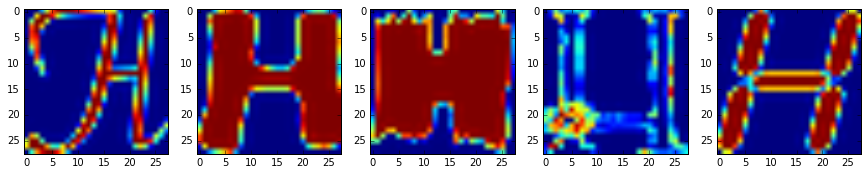

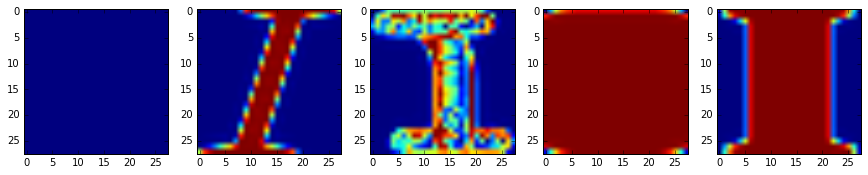

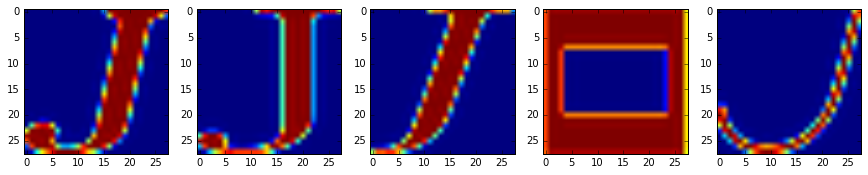

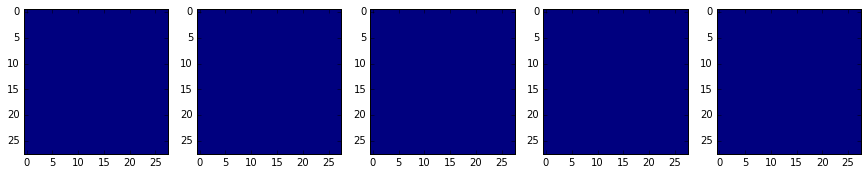

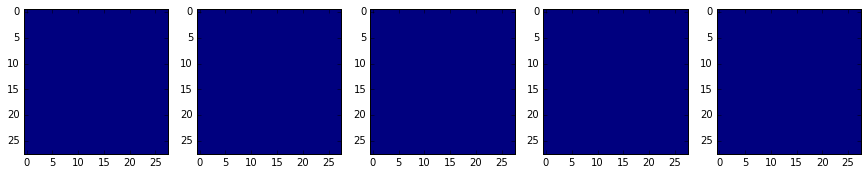

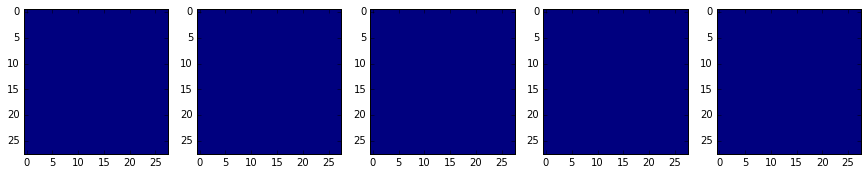

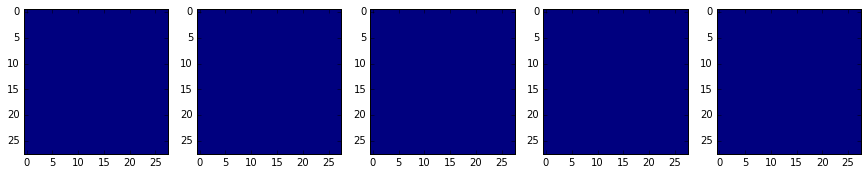

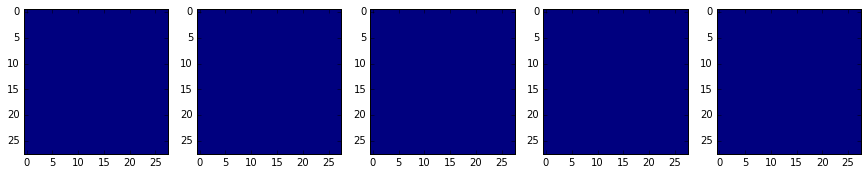

In [17]:
print("Verifing train set")
for label in np.unique(train_labels):
    label_indexes = np.nonzero(train_labels==label); #get the indices of values equal to label
    label_examples = train_dataset[label_indexes];
    print("Examples for ",label);
    myFigure = plt.figure();
    myFigure.set_figwidth(15);
    myFigure.set_figheight(15); 
    
    for img in range(0,5):
        image_number = int(np.random.choice(len(label_examples),1));
        ax = myFigure.add_subplot(1, 5, img+1)
        ax = plt.imshow(label_examples[image_number]);
    display(myFigure);



Verifing validation set
Examples for  0


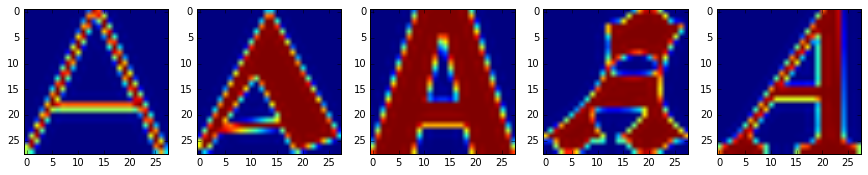

Examples for  1


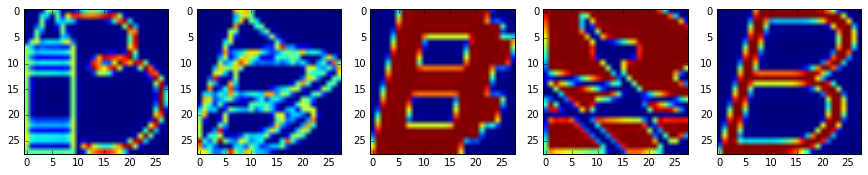

Examples for  2


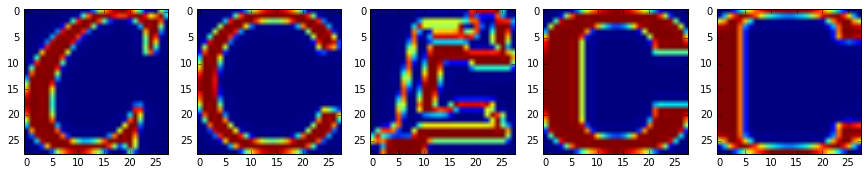

Examples for  3


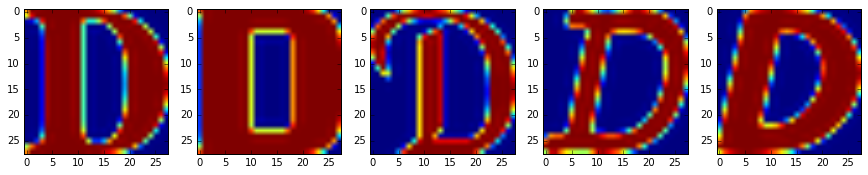

Examples for  4


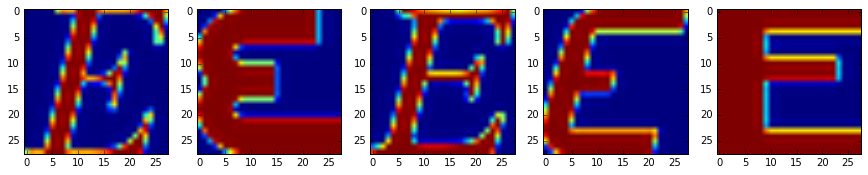

Examples for  5


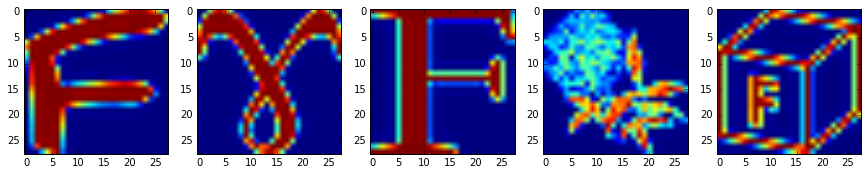

Examples for  6


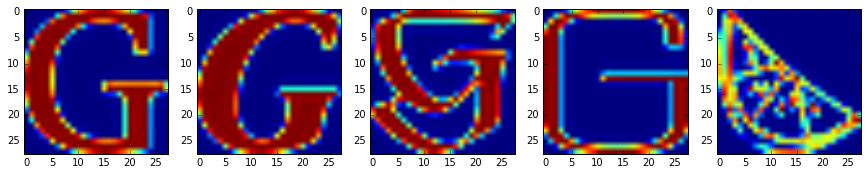

Examples for  7


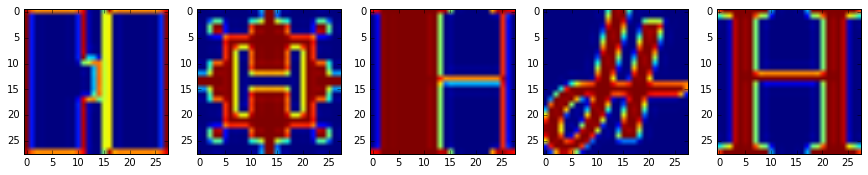

Examples for  8


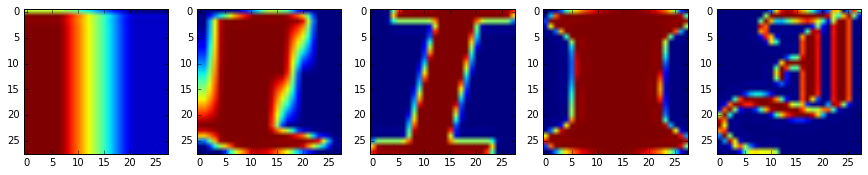

Examples for  9


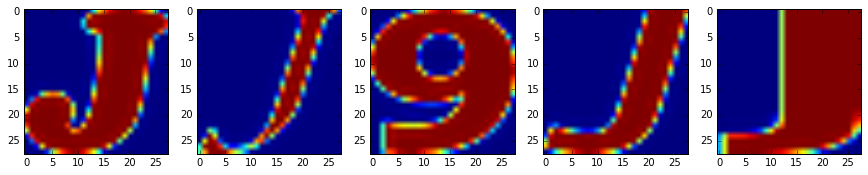

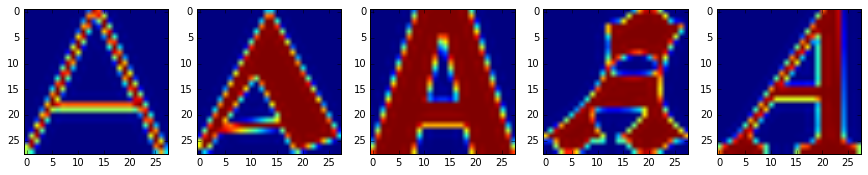

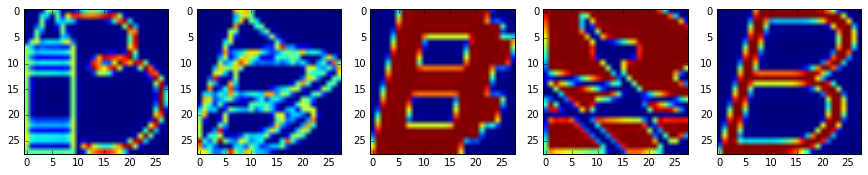

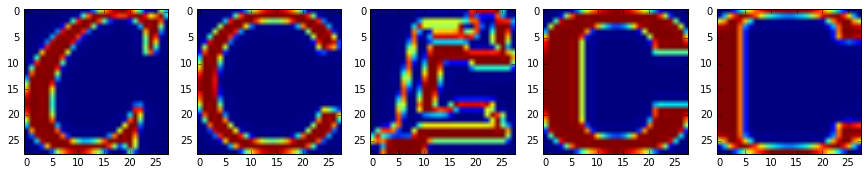

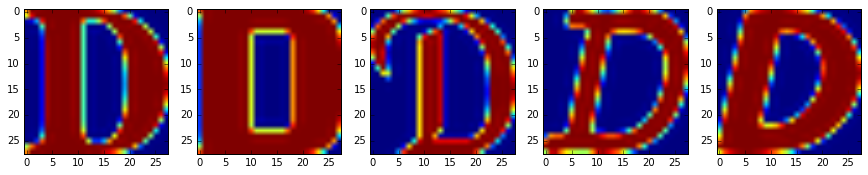

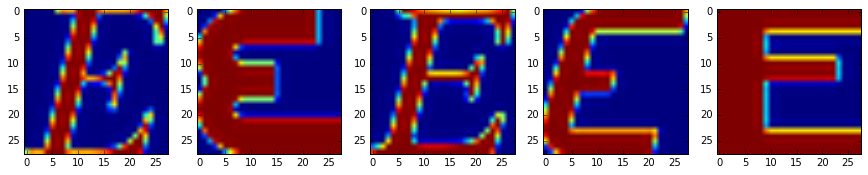

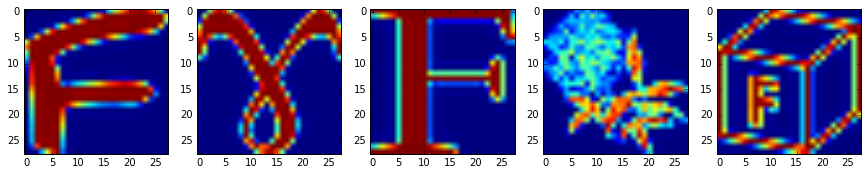

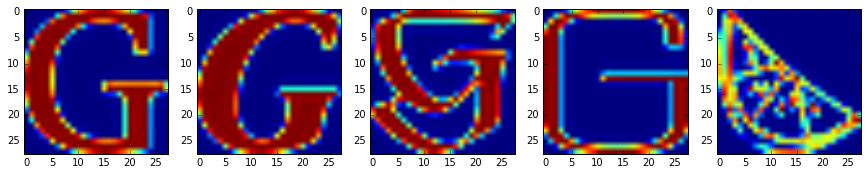

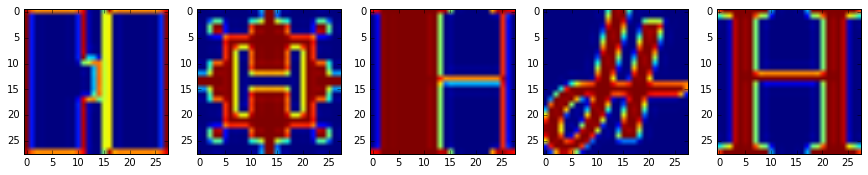

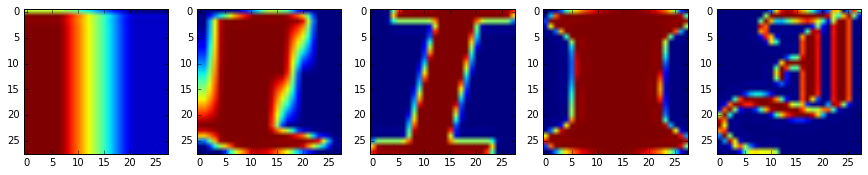

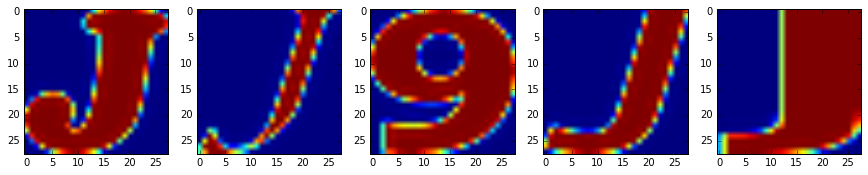

In [18]:
print("Verifing validation set")
for label in np.unique(valid_labels):
    label_indexes = np.nonzero(valid_labels==label); #get the indices of values equal to label
    label_examples = valid_dataset[label_indexes];
    print("Examples for ",label);
    myFigure = plt.figure();
    myFigure.set_figwidth(15);
    myFigure.set_figheight(15); 
    
    for img in range(0,5):
        image_number = int(np.random.choice(len(label_examples),1));
        ax = myFigure.add_subplot(1, 5, img+1)
        ax = plt.imshow(label_examples[image_number]);
    display(myFigure);

Verifing test set
Examples for  0


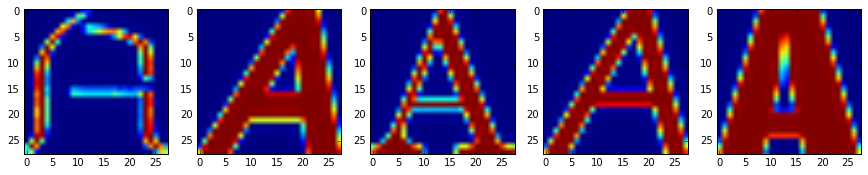

Examples for  1


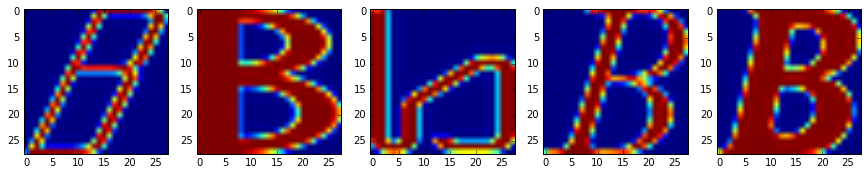

Examples for  2


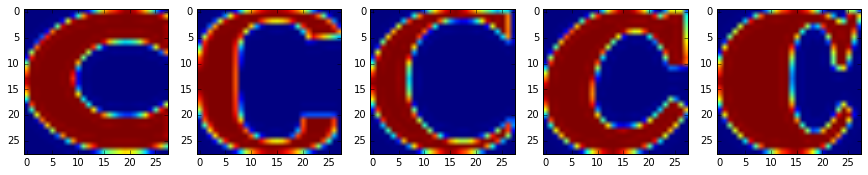

Examples for  3


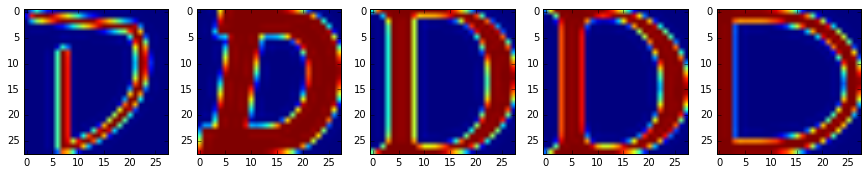

Examples for  4


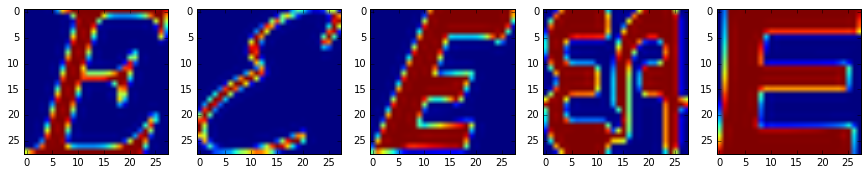

Examples for  5


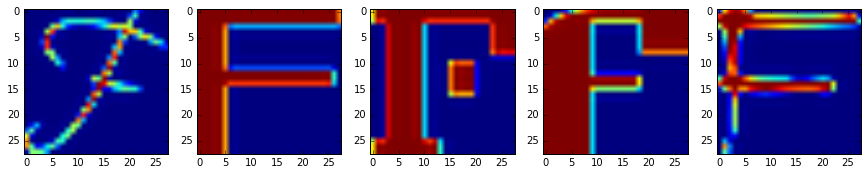

Examples for  6


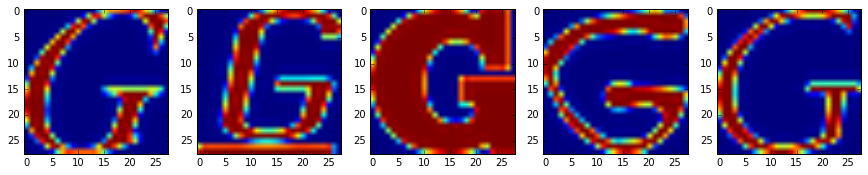

Examples for  7


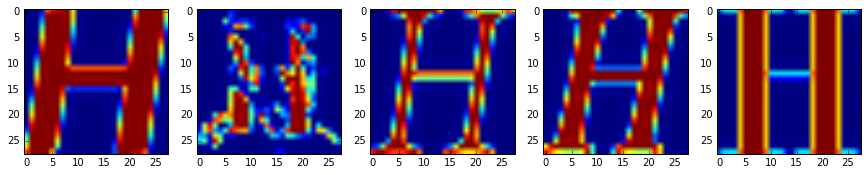

Examples for  8


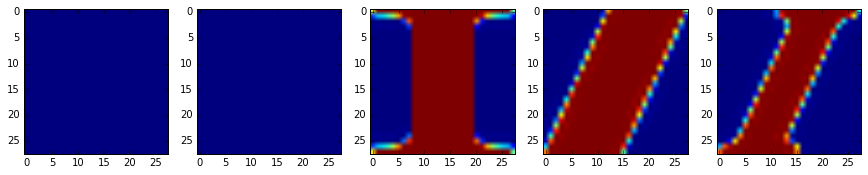

Examples for  9


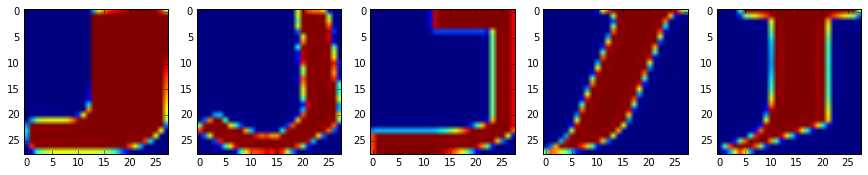

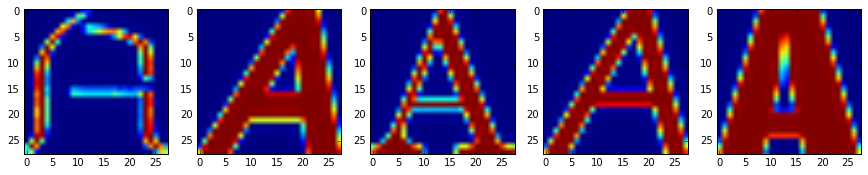

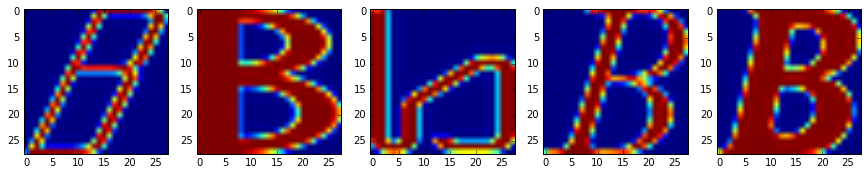

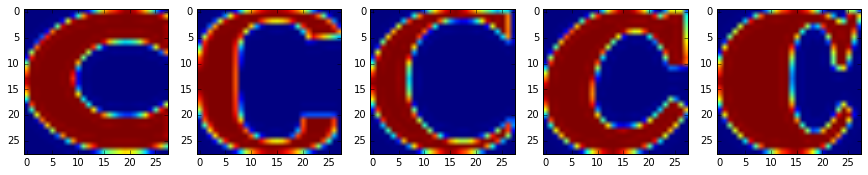

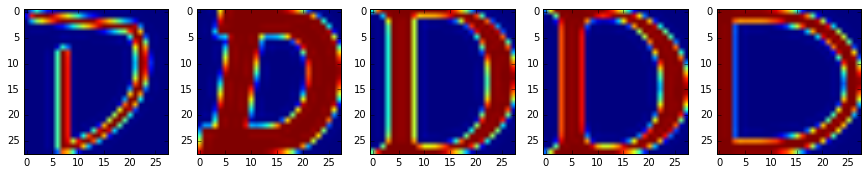

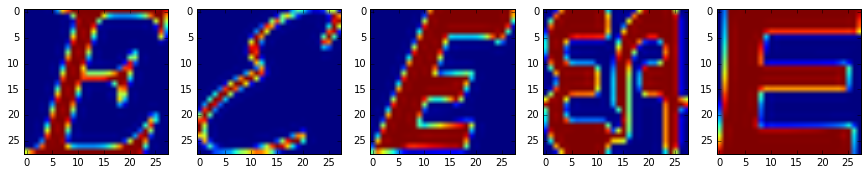

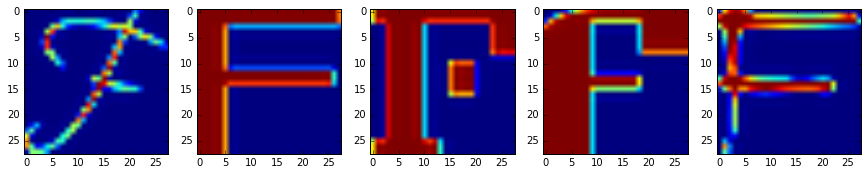

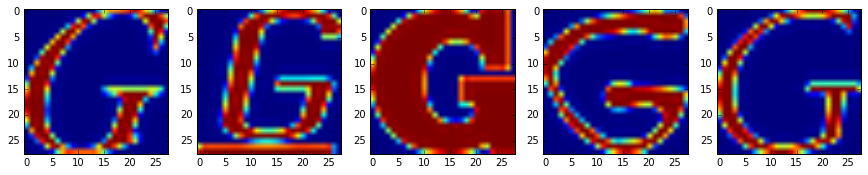

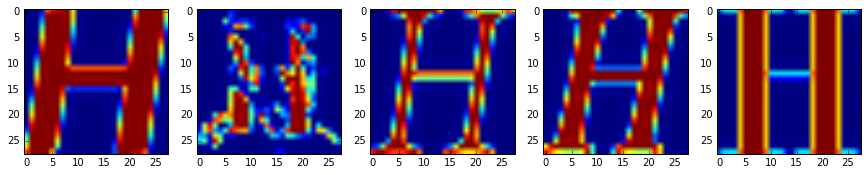

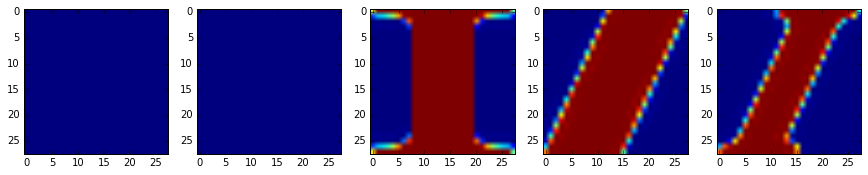

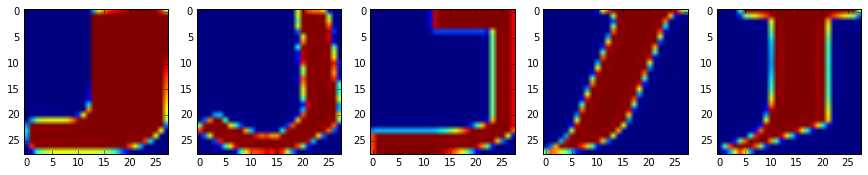

In [19]:
print("Verifing test set")
for label in np.unique(valid_labels):
    label_indexes = np.nonzero(test_labels==label); #get the indices of values equal to label
    label_examples = test_dataset[label_indexes];
    print("Examples for ",label);
    myFigure = plt.figure();
    myFigure.set_figwidth(15);
    myFigure.set_figheight(15); 
    
    for img in range(0,5):
        image_number = int(np.random.choice(len(label_examples),1));
        ax = myFigure.add_subplot(1, 5, img+1)
        ax = plt.imshow(label_examples[image_number]);
    display(myFigure);

Finally, let's save the data for later reuse:

In [20]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 225794697


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [22]:
import hashlib
import time

def measure_overlap(a, b):
  '''a and b are ndarrays of shape (len, 28, 28)'''
  a.flags.writeable = False; b.flags.writeable = False
  
  start = time.clock()
  
  a_hashed = [hashlib.sha1(i).hexdigest() for i in a]
  b_hashed = [hashlib.sha1(i).hexdigest() for i in b]
  a_set = set(a_hashed)
  b_set = set(b_hashed)
  
  overlap = set.intersection(a_set, b_set)
  overlap_aInb = filter(lambda x: x in b_set, a_hashed)
  overlap_bIna = filter(lambda x: x in a_set, b_hashed)
  
  return overlap, overlap_aInb, overlap_bIna, time.clock() - start

tv_dups, tInv, vInt, tv_time = measure_overlap(train_dataset, valid_dataset)
tt_dups, trInte, teIntr, tt_time = measure_overlap(train_dataset, test_dataset)

print("Between Train and Validation: %d overlaps, %d Train in Validation, %d Validation in Train, %.2f sec"%(len(tv_dups), len(tInv), len(vInt), tv_time))
print("Between Train and Test: %d overlaps, %d Train in Test, %d Test in Train, %.2f sec"%(len(tt_dups), len(trInte), len(teIntr), tt_time))

Between Train and Validation: 299 overlaps, 915 Train in Validation, 430 Validation in Train, 0.26 sec
Between Train and Test: 323 overlaps, 893 Train in Test, 470 Test in Train, 0.27 sec


In [23]:
#create sanitized sets
def sanitize(a, a_labels, b):
  '''sanitize a based on b'''
  start = time.clock()
  
  a_hashed = [hashlib.sha1(i).hexdigest() for i in a]
  b_hashed = [hashlib.sha1(i).hexdigest() for i in b]
  aNotInb = ~ np.in1d(a_hashed, b_hashed)
  
#   b_set = set([hashlib.sha1(i).hexdigest() for i in b])
#   a_dict = dict(zip(a_hashed, a))
#   aNotInb = filter(lambda x: x not in b_set, a_hashed)
#   a_sanitized = { k: a_dict[k] for k in aNotInb }

  return a[aNotInb], a_labels[aNotInb], time.clock() - start

valid_snt, valid_labels_snt, vt = sanitize(valid_dataset, valid_labels, train_dataset)
test_snt, test_labels_snt, tt = sanitize(test_dataset, test_labels, train_dataset)

print("Sanitized Validation dataset contains %d images, %.2f sec"%(len(valid_snt), vt))
print("Sanitized Test dataset contains %d images, %.2f sec"%(len(test_snt), tt))


Sanitized Validation dataset contains 9570 images, 0.28 sec
Sanitized Test dataset contains 9530 images, 0.29 sec


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [27]:
#reshape data matrix to vector
def reshape_dataset(data):
    data = data.reshape(len(data),-1);
    return data;
#create a function that trains a logistic regression model for a number of examples(and returns it to evaluation)
def train_logistic_regression(data,output,size):
    data = reshape_dataset(data);
    data_indices =  np.random.choice(len(data),size,False);
    model = LogisticRegression();
    model.fit(data[data_indices],output[data_indices]);
    return model;

In [33]:
#reshape validation ,and testsets
valid_dataset = reshape_dataset(valid_dataset);

#train for 50 examples
model50 = train_logistic_regression(train_dataset,train_labels,50);
print("Accurracy for model with 50 training",model50.score(valid_dataset,valid_labels));

#train for  100 examples
model100 = train_logistic_regression(train_dataset,train_labels,100);
print("Acurracy for model with 100  training,",model100.score(valid_dataset,valid_labels));

model1000 = train_logistic_regression(train_dataset,train_labels,1000);
print("Acurracy for model with 1000",model1000.score(valid_dataset,valid_labels));

model5000 = train_logistic_regression(train_dataset,train_labels,5000);
print("Accurracy for model with 5000",model5000.score(valid_dataset,valid_labels));

Accurracy for model with 50 training 0.6041
Acurracy for model with 100  training, 0.6827
Acurracy for model with 1000 0.767
Accurracy for model with 5000 0.7765


In [34]:
#train with all data
data = reshape_dataset(train_dataset);
model = LogisticRegression();
model.fit(data,train_labels);
print("Accurracy for of the shelf model",model.score(valid_dataset,valid_labels));

Accurracy for of the shelf model 0.8214
